Introduction for Psychologists:

Hello. This is a demo of our model on predicting depression risk and explaining with features and cases. It is trained on a data set of cases.

**Case**: a survey participant who answered 102 questions of depression screening survey (self-reporting). Each participant has a depression risk score 0,1,2 (judged by a psychologist, based on number of depression-related physical symptoms)

**Feature**: Answers to survey questions (yes/no)

**Query**: the new client who we are making a prediction on.

**How does it work:**
 Our model learns about important features and cases during training. Given a new query (a new client), our model makes a prediction by retrieving the most relevant cases. It can explain in two main ways: highlighting (non-)important features, or highlighting (non-)important cases.

**Goal**: The Goal of this demo is not to show you how good or how bad our model performs but more to open up a discussion about what you feel about using such models (part 2 of the interview). Please ignore the non-existing User-experience (UI) and the software code aspects because it is just a prototype. I will do my best to show you only the relevant parts.

# 1 Setup

On google colab, you have to restart runtime after running the following line

In [ ]:
!pip install omegaconf

In [ ]:
from google.colab import drive
drive.mount("/content/drive/")
#"/content/drive/My Drive/NN-kNN/"

# For Ye
# folder_name = "/content/drive/Othercomputers/My MacBook Pro/GitHub/NN-kNN/"

#For everyone else
folder_name = "/content/drive/MyDrive/NN-kNN/"

import sys
sys.path.insert(0,folder_name)

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [ ]:
##This is added because my Rdata uses Cdata for the covid data set.
##Rdata use Cdata function to load the data set, then convert it to regression problem
import os
import sys
sys.path.append(folder_name + 'dataset')


In [ ]:
import torch
import os
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score
from sklearn.neighbors import KNeighborsClassifier, KNeighborsRegressor
from sklearn.metrics import mean_squared_error
from tqdm import tqdm
from omegaconf import DictConfig, OmegaConf

from dataset import cls_small_data as Cdata
import model.cls_model as Cmodel
from dataset import cls_medium_data

from dataset import reg_data as Rdata
import model.reg_model as Rmodel

In [ ]:
conf_file = OmegaConf.load(os.path.join(folder_name, 'config.yaml'))

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
torch.cuda.is_available()

True

In [ ]:
random_seed = 43

# NCA and LMNN setup

In [ ]:
pip install metric-learn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.8/67.8 kB 3.6 MB/s eta 0:00:00


In [ ]:
import metric_learn
from metric_learn import LMNN,NCA

# 2 Data Sets

Supported small dataset for classification:  
'zebra',
'zebra_special',
'bal',
'digits',
'iris',
'wine',
'breast_cancer',

for regression:
'califonia_housing',
'abalone',
'diabets',
'body_fat',
'ziweifaces'


Newly added data sets for mental health (psychology):

Classification:
'psych_depression_physical_symptons',
'covid_anxious',
'covid_depressed'


In [ ]:
dataset_name = 'psych_depression_physical_symptons'
cfg = conf_file['dataset'][dataset_name]
#TODO need to add other covid data sets here.
if dataset_name in ['covid_anxious','covid_depressed','covid_physical','covid_lonely','covid_hopeless',
                    'psych_depression_physical_symptons',
                    'zebra','zebra_special','bal','digits','iris','wine','breast_cancer']:
    criterion = torch.nn.CrossEntropyLoss()
    Xs, ys = Cdata.Cls_small_data(dataset_name, folder_name)
elif dataset_name in []:
    criterion = torch.nn.CrossEntropyLoss()
    Xs, ys = cls_medium_data.Cls_medium_data(dataset_name)
else:
    criterion = torch.nn.MSELoss()
    Xs, ys = Rdata.Reg_data(dataset_name)

['1. Most of the time I have difficulty concentrating on simple tasks', "2. I don't feel like doing my daily duties", '3. My friends or family have told me that I look different', '4. When I think about the future it is difficult for me to imagine it clearly', '5. People around me often ask me how I feel', '6. I consider that my life is full of good things', '7. My hobbies are still important to me', "8. I'm still as punctual as I have always been", '9. If I had the chance, I would spend all day in my bed', '10. I have found that I can spend a lot of time scrolling the screen \nof my cell phone without searching or stopping at anything in particular', '11. When someone asks me something, I have noticed that I take longer than normal to\nrespond', '12. I have noticed my body shaken without any cause', '13. I felt more encouraged to do my daily activities before', "14. Sometimes I wake up sad and I can't explain why", '15. In recent months I usually reproach myself for things from the pa

In [ ]:
# for dataset "psych_depression_physical_symptons"
columns = ['1. Most of the time I have difficulty concentrating on simple tasks', "2. I don't feel like doing my daily duties", '3. My friends or family have told me that I look different', '4. When I think about the future it is difficult for me to imagine it clearly', '5. People around me often ask me how I feel', '6. I consider that my life is full of good things', '7. My hobbies are still important to me', "8. I'm still as punctual as I have always been", '9. If I had the chance, I would spend all day in my bed', '10. I have found that I can spend a lot of time scrolling the screen \nof my cell phone without searching or stopping at anything in particular', '11. When someone asks me something, I have noticed that I take longer than normal to\nrespond', '12. I have noticed my body shaken without any cause', '13. I felt more encouraged to do my daily activities before', "14. Sometimes I wake up sad and I can't explain why", '15. In recent months I usually reproach myself for things from the past', '16. I think my thoughts are strange or different from before', '17. I feel guilty about the decisions that I have made', "18. I don't feel as comfortable with my body as I did before", "19. I don't feel successful compared to others", '20. It is difficult for me to make decisions even if they are simple', "21. I'm capable of achieving what I propose to myself", '22. It is not difficult for me to understand something the first time', '23. I have thought more than before about what my death would be like', '24. Being dead seems to be a solution to some problems', '25. I would rather stay home than go out with my friends', '26. I like to attend family gatherings', '27. I feel excited when thinking about my life project', '28. The decisions I have made so far have been the right ones', '29. I am able to carry out my activities as I have always been', '30. I like to be in touch with my friends and family through social media', '31. It is easy for me to choose a photograph of myself to show it on social media', '32. I am proud of what I have achieved so far', '33. I have trouble remembering things easily', '34. In recent months I have had discussions with my schoolmates or colleagues', '35. I constantly imagine that something will go wrong at my work or at school', '36. I am afraid of being worng when doing my homework', "37. I'm not too worried about what might happen in a few weeks", "38. Lately it's hard for me to calm down", '39. Everything will be alright', '40. I can easily blank my mind', '41. I am bothered by insignificant things that were not important before', '42. I find it uncomfortable to be in a crowded place', '43. Sometimes i feel trapped', '44. I am easily frightened by unexpected noises', '45. I have difficulties to do one task at a time', '46. I have the feeling that I am forgetting to do something', '47. I can clearly express to others how I feel', '48. I can sleep easily', '49. I enjoy every moment of the day', '50. I imagine that at any moment a disaster of the\nnature may occur', '51. Sometimes I feel like I get tired easily', '52. Being locked in an elevator would be the worst thing that could happen to me', "53. I'm bothered by people walking slowly in front of me ", "54. I don't usually get upset if something doesn't go as expected", '55. Sometimes it is as if some conversations with friends or family become\ninterrogations', '56. I manage my schedule as I always have', '57. It bothers me to feel that people on the street approach me', '58. I have no difficulty understanding what people explain to me', '59. I consider that I am good at controlling my emotions', '60. In new situations I feel calm and encouraged', '61. Sometimes I forget what I wanted to say because I have several thoughts at the same time', '62. I would like to know what will happen in the future', '63. When I get angry I can easily explode', '64. I can put down my cell phone and dedicate myself to reading without distractions', '65. I worry that people will not understand what I mean.', '66. Sometimes I do not listen to what people say to me because I am thinking about other things', '67. I get angry easily', "68. I'm afraid that something bad could happen to me", '69. It is not important for me to meet set dates', '70. I like to think clearly before giving my opinion', '71. I use lies just to get out of certain problems', '72. If I have the opportunity to get in line to avoid wasting time, I do it', '73. I have difficulty making elaborate plans', '74. People have problems because of themselves', '75. No me parece importante lo que los otros piensen sobre mí', '76. Laws are not as important as others think', '77. I would regret betraying a friend', '78. I prefer that a negotiation supports the largest possible number of people involved', '79. It is easy for me to work in a team', '80. It is important to help people when they need it', '81. I have punched someone or thought of doing it', '82. If it was necessary I would pretend to be someone else to get something', '83. I consider it important to ensure my physical safety and that of those around me', '84. After an argument I usually go over what happened in my head', '85. I have a hard time controlling myself when I get angry', '86. Loyalty is important', "87. If I can help a person I will stop what I'm doing to help him", '88', '89. It makes me laugh when my superiors at school or at work demand something', '90. Deceiving people is not wrong if it is to achieve something important', '91. I like to greet my neighbors', '92. It does not seem serious to me to have some debts', '93. People steal because they have needs', '94. I lose control easily', "95. Neighbors must put up with each other's noises without complaining", '96. Littering on public roads is wrong', '97. People who commit crimes have their reasons for doing it', '98. It is normal to change jobs several times a year', '99. It is important to respect turns', '100. I could pretend to be someone else to achieve what I want', '101. I consider it important that all people have the same rights', '102. I have a hard time taking  "no" for an answer']


In [ ]:
columns

['1. Most of the time I have difficulty concentrating on simple tasks',
 "2. I don't feel like doing my daily duties",
 '3. My friends or family have told me that I look different',
 '4. When I think about the future it is difficult for me to imagine it clearly',
 '5. People around me often ask me how I feel',
 '6. I consider that my life is full of good things',
 '7. My hobbies are still important to me',
 "8. I'm still as punctual as I have always been",
 '9. If I had the chance, I would spend all day in my bed',
 '10. I have found that I can spend a lot of time scrolling the screen \nof my cell phone without searching or stopping at anything in particular',
 '11. When someone asks me something, I have noticed that I take longer than normal to\nrespond',
 '12. I have noticed my body shaken without any cause',
 '13. I felt more encouraged to do my daily activities before',
 "14. Sometimes I wake up sad and I can't explain why",
 '15. In recent months I usually reproach myself for thin

In [ ]:
columns[0]

'1. Most of the time I have difficulty concentrating on simple tasks'

In [ ]:
columns[101]

'102. I have a hard time taking  "no" for an answer'

In [ ]:
# This section is used to reload the imported module.
# For example, if you made any changes in the model.cls_model, you should run importlib.reload(Cmodel) as long as you set import model.cls_model as Cmodel.
import importlib
importlib.reload(Rdata)
importlib.reload(Cdata)

<module 'dataset.cls_small_data' from '/content/drive/MyDrive/NN-kNN/dataset/cls_small_data.py'>

In [ ]:
#for reloading config file, in case you modified it for experimenting
conf_file = OmegaConf.load(os.path.join(folder_name, 'config.yaml'))
cfg = conf_file['dataset'][dataset_name]

In [ ]:
cfg

{'ca_weight_sharing': True, 'top_case_enabled': False, 'training_epochs': 1000, 'learning_rate': 0.01, 'batch_size': 4, 'top_k': 5, 'class_weight_sharing': True, 'patience': 40, 'discount': 2}

In [ ]:
#cfg.top_case_enabled = True
# cfg.ca_weight_sharing=False

In [ ]:
Xs.shape

torch.Size([117, 102])

# 3 Training. Classification with NN-kNN

In [ ]:
# prompt: get the unique y values and their counts

unique_values, counts = np.unique(ys, return_counts=True)
print(f"Unique values: {unique_values}")
print(f"Counts: {counts}")
print(f"Xs.size(): {Xs.size()}")


Unique values: [0 1 2]
Counts: [39 39 39]
Xs.size(): torch.Size([117, 102])


In [ ]:
def train_cls(X_train,y_train, X_test, y_test, cfg:DictConfig):
  X_train = X_train.to(device)
  y_train = y_train.to(device)
  X_test = X_test.to(device)

  train_loader = torch.utils.data.DataLoader(torch.utils.data.TensorDataset(X_train, y_train), batch_size=cfg.batch_size,
                                             shuffle=True) #, random_state = 42)
  torch.manual_seed(2809)

  # Train model
  # X_train_trimmed = X_train[:, :X_train.shape[1]//10]
  # y_train_trimmed = y_train[:X_train.shape[1]//10]
  model = Cmodel.NN_k_NN(X_train,
              y_train,
              cfg.ca_weight_sharing,
              cfg.top_case_enabled,
              cfg.top_k,
              cfg.discount,
              device=device)

  optimizer = torch.optim.Adam(model.parameters(), lr=cfg.learning_rate) #, weight_decay=1e-5)

  patience_counter = 0
  for epoch in range(cfg.training_epochs):
    epoch_msg = True

    for X_train_batch, y_train_batch in train_loader:
      model.train()
      _, _, output, predicted_class = model(X_train_batch)
      loss = criterion(output, y_train_batch)

      # Backward and optimize
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()
      if epoch_msg and (epoch + 1) % 2 == 0:
        print(f'Epoch [{epoch + 1}/{cfg.training_epochs}], Loss: {loss.item():.4f}')

        epoch_msg = False
      # print("evaluating")
    model.eval()
    with torch.no_grad():
      _, _, output, predicted_class = model(X_test)

      # Calculate accuracy
      accuracy_temp = accuracy_score(y_test.numpy(), predicted_class.cpu().numpy())
    if epoch == 0:
      best_accuracy = accuracy_temp
      torch.save(model.state_dict(), cfg.PATH)

    elif accuracy_temp > best_accuracy:
      #memorize best model
      torch.save(model.state_dict(), cfg.PATH)
      best_accuracy = accuracy_temp
      patience_counter = 0

    elif patience_counter > cfg.patience:
      print("patience exceeded, loading best model")
      model = load_model_cls(X_train,y_train,cfg)
      model.eval()
      break
    else:
      patience_counter += 1

  return best_accuracy, model

In [ ]:
def load_model_cls(X_train,y_train,cfg):
  # Define the model architecture
  model = Cmodel.NN_k_NN(
      X_train,
      y_train,
      cfg.ca_weight_sharing,
      cfg.top_case_enabled,
      cfg.top_k,
      cfg.discount,
      device=device
  )
  # Load the state dictionary
  model.load_state_dict(torch.load(cfg.PATH))
  model.to(device)
  model.eval()
  return model

In [ ]:
accuracies = []
knn_accuracies = []
lmnn_accuracies = []
PATH = os.path.join(folder_name, f'checkpoints/classifier_{dataset_name}.h5')
cfg.PATH = PATH
k_fold = KFold(n_splits=10, shuffle=True, random_state = random_seed)
enable_lmnn = False

for train_index, test_index in k_fold.split(Xs):
  # Get training and testing data
  X_train, X_test = Xs[train_index], Xs[test_index]
  y_train, y_test = ys[train_index], ys[test_index]
  if(enable_lmnn):
    # https://contrib.scikit-learn.org/metric-learn/supervised.html#lmnn
    lmnn = LMNN(n_neighbors=5, learn_rate=1e-6)
    ##TODO, change here if you need to use a different one
    # lmnn = metric_learn.MLKR()
    # lmnn = metric_learn.NCA(max_iter=1000)
    lmnn.fit(X_train,y_train)
    knn = KNeighborsClassifier(n_neighbors=5,metric=lmnn.get_metric())
    knn.fit(X_train,y_train)
    # klmnn_accuracies.append( accuracy_score(knn.predict(X_test), y_test))
    lmnn_acc = accuracy_score(knn.predict(X_test), y_test)
    lmnn_accuracies.append(lmnn_acc)
    print("lmnn_acc: ",lmnn_acc)
    # continue

  knn =  KNeighborsClassifier(n_neighbors=cfg.top_k)
  knn.fit(X_train, y_train)
  knn_acc  = accuracy_score(knn.predict(X_test), y_test)
  knn_accuracies.append(knn_acc)
  print("knn_acc: ", knn_acc)

  best_accuracy, model = train_cls(X_train,y_train, X_test, y_test, cfg)
  accuracies.append(best_accuracy)
  print("nnknn acc: ", best_accuracy)


print(f"Average accuracy:{np.mean(accuracies):.3f}")
print(f"KNN accuracy:{np.mean(knn_accuracies):.3f}")
print(f"LMNN/NCA accuracy:{np.mean(lmnn_accuracies):.3f}")


knn_acc:  0.5833333333333334
Epoch [2/1000], Loss: 3.3283
Epoch [4/1000], Loss: 1.5247
Epoch [6/1000], Loss: 2.2188
Epoch [8/1000], Loss: 2.1457
Epoch [10/1000], Loss: 1.3078
Epoch [12/1000], Loss: 1.7858
Epoch [14/1000], Loss: 1.6105
Epoch [16/1000], Loss: 0.6517
Epoch [18/1000], Loss: 1.1477
Epoch [20/1000], Loss: 1.3917
Epoch [22/1000], Loss: 0.0939
Epoch [24/1000], Loss: 0.5905
Epoch [26/1000], Loss: 1.6224
Epoch [28/1000], Loss: 1.0614
Epoch [30/1000], Loss: 0.7379
Epoch [32/1000], Loss: 1.4325
Epoch [34/1000], Loss: 0.7021
Epoch [36/1000], Loss: 1.6493
Epoch [38/1000], Loss: 0.7676
Epoch [40/1000], Loss: 0.4989
Epoch [42/1000], Loss: 0.7793
Epoch [44/1000], Loss: 0.3715
Epoch [46/1000], Loss: 0.7365
Epoch [48/1000], Loss: 0.6776
Epoch [50/1000], Loss: 0.4954
Epoch [52/1000], Loss: 0.6368
Epoch [54/1000], Loss: 0.4657
Epoch [56/1000], Loss: 0.8031
Epoch [58/1000], Loss: 0.3674
Epoch [60/1000], Loss: 0.5912
Epoch [62/1000], Loss: 0.4726
Epoch [64/1000], Loss: 0.3191
Epoch [66/1000]

<ipython-input-23-735e1fd27a5e>:13: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(cfg.PATH))


Epoch [4/1000], Loss: 1.9418
Epoch [6/1000], Loss: 1.2996
Epoch [8/1000], Loss: 1.7492
Epoch [10/1000], Loss: 1.9460
Epoch [12/1000], Loss: 1.5181
Epoch [14/1000], Loss: 1.5065
Epoch [16/1000], Loss: 0.9890
Epoch [18/1000], Loss: 1.5378
Epoch [20/1000], Loss: 1.6079
Epoch [22/1000], Loss: 1.1925
Epoch [24/1000], Loss: 0.6100
Epoch [26/1000], Loss: 1.0699
Epoch [28/1000], Loss: 1.0675
Epoch [30/1000], Loss: 0.6229
Epoch [32/1000], Loss: 0.6458
Epoch [34/1000], Loss: 0.5805
Epoch [36/1000], Loss: 0.5858
Epoch [38/1000], Loss: 0.4299
Epoch [40/1000], Loss: 0.2886
Epoch [42/1000], Loss: 0.5434
Epoch [44/1000], Loss: 0.2986
Epoch [46/1000], Loss: 0.9438
Epoch [48/1000], Loss: 0.4258
Epoch [50/1000], Loss: 0.2780
Epoch [52/1000], Loss: 0.4290
Epoch [54/1000], Loss: 0.8605
Epoch [56/1000], Loss: 0.4552
Epoch [58/1000], Loss: 0.6345
Epoch [60/1000], Loss: 1.1282
Epoch [62/1000], Loss: 0.5909
Epoch [64/1000], Loss: 0.1661
Epoch [66/1000], Loss: 0.4339
Epoch [68/1000], Loss: 0.6711
patience exce

<ipython-input-23-735e1fd27a5e>:13: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(cfg.PATH))


Epoch [2/1000], Loss: 1.8526
Epoch [4/1000], Loss: 2.1662
Epoch [6/1000], Loss: 2.3520
Epoch [8/1000], Loss: 1.8183
Epoch [10/1000], Loss: 1.2150
Epoch [12/1000], Loss: 0.2562
Epoch [14/1000], Loss: 0.6995
Epoch [16/1000], Loss: 1.6997
Epoch [18/1000], Loss: 0.8168
Epoch [20/1000], Loss: 0.8231
Epoch [22/1000], Loss: 0.8326
Epoch [24/1000], Loss: 0.5661
Epoch [26/1000], Loss: 0.2955
Epoch [28/1000], Loss: 0.2707
Epoch [30/1000], Loss: 0.2356
Epoch [32/1000], Loss: 1.1477
Epoch [34/1000], Loss: 0.8401
Epoch [36/1000], Loss: 0.6712
Epoch [38/1000], Loss: 0.2725
Epoch [40/1000], Loss: 0.6058
Epoch [42/1000], Loss: 0.7208
Epoch [44/1000], Loss: 0.6351
Epoch [46/1000], Loss: 0.3730
Epoch [48/1000], Loss: 0.5189
Epoch [50/1000], Loss: 0.2473
Epoch [52/1000], Loss: 0.2637
Epoch [54/1000], Loss: 0.4033
Epoch [56/1000], Loss: 0.2869
Epoch [58/1000], Loss: 0.1585
Epoch [60/1000], Loss: 0.5021
Epoch [62/1000], Loss: 0.2782
Epoch [64/1000], Loss: 0.2327
Epoch [66/1000], Loss: 0.3292
Epoch [68/1000

<ipython-input-23-735e1fd27a5e>:13: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(cfg.PATH))


Epoch [2/1000], Loss: 2.3455
Epoch [4/1000], Loss: 1.7043
Epoch [6/1000], Loss: 1.7145
Epoch [8/1000], Loss: 2.1587
Epoch [10/1000], Loss: 0.7241
Epoch [12/1000], Loss: 1.2016
Epoch [14/1000], Loss: 1.4881
Epoch [16/1000], Loss: 1.8024
Epoch [18/1000], Loss: 0.4886
Epoch [20/1000], Loss: 0.9473
Epoch [22/1000], Loss: 1.2089
Epoch [24/1000], Loss: 0.8164
Epoch [26/1000], Loss: 0.2777
Epoch [28/1000], Loss: 0.7218
Epoch [30/1000], Loss: 0.2896
Epoch [32/1000], Loss: 0.7924
Epoch [34/1000], Loss: 0.5799
Epoch [36/1000], Loss: 0.5251
Epoch [38/1000], Loss: 0.5624
Epoch [40/1000], Loss: 0.6557
Epoch [42/1000], Loss: 0.7185
Epoch [44/1000], Loss: 0.4334
Epoch [46/1000], Loss: 0.5511
Epoch [48/1000], Loss: 0.2301
Epoch [50/1000], Loss: 0.3892
Epoch [52/1000], Loss: 0.5452
Epoch [54/1000], Loss: 0.4144
patience exceeded, loading best model
nnknn acc:  0.6666666666666666
knn_acc:  0.75


<ipython-input-23-735e1fd27a5e>:13: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(cfg.PATH))


Epoch [2/1000], Loss: 2.1257
Epoch [4/1000], Loss: 1.6101
Epoch [6/1000], Loss: 2.2093
Epoch [8/1000], Loss: 2.1310
Epoch [10/1000], Loss: 1.2909
Epoch [12/1000], Loss: 1.5154
Epoch [14/1000], Loss: 1.4005
Epoch [16/1000], Loss: 0.8632
Epoch [18/1000], Loss: 1.2656
Epoch [20/1000], Loss: 1.4993
Epoch [22/1000], Loss: 1.4541
Epoch [24/1000], Loss: 1.1212
Epoch [26/1000], Loss: 0.6179
Epoch [28/1000], Loss: 0.3996
Epoch [30/1000], Loss: 0.4308
Epoch [32/1000], Loss: 0.9232
Epoch [34/1000], Loss: 0.8137
Epoch [36/1000], Loss: 0.8946
Epoch [38/1000], Loss: 1.1760
Epoch [40/1000], Loss: 0.4967
Epoch [42/1000], Loss: 0.5880
Epoch [44/1000], Loss: 0.2538
Epoch [46/1000], Loss: 1.1465
Epoch [48/1000], Loss: 0.5225
Epoch [50/1000], Loss: 0.6322
Epoch [52/1000], Loss: 0.7213
Epoch [54/1000], Loss: 0.4980
Epoch [56/1000], Loss: 0.6996
Epoch [58/1000], Loss: 0.3917
Epoch [60/1000], Loss: 0.1389
Epoch [62/1000], Loss: 0.4493
Epoch [64/1000], Loss: 0.5113
Epoch [66/1000], Loss: 0.5195
Epoch [68/1000

<ipython-input-23-735e1fd27a5e>:13: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(cfg.PATH))


Epoch [4/1000], Loss: 2.2140
Epoch [6/1000], Loss: 1.9728
Epoch [8/1000], Loss: 1.4509
Epoch [10/1000], Loss: 0.5112
Epoch [12/1000], Loss: 1.0076
Epoch [14/1000], Loss: 1.2242
Epoch [16/1000], Loss: 0.7218
Epoch [18/1000], Loss: 0.5211
Epoch [20/1000], Loss: 0.1798
Epoch [22/1000], Loss: 0.4225
Epoch [24/1000], Loss: 0.8200
Epoch [26/1000], Loss: 0.4588
Epoch [28/1000], Loss: 0.1783
Epoch [30/1000], Loss: 0.3235
Epoch [32/1000], Loss: 0.8577
Epoch [34/1000], Loss: 0.5649
Epoch [36/1000], Loss: 0.6307
Epoch [38/1000], Loss: 0.5276
Epoch [40/1000], Loss: 0.7961
Epoch [42/1000], Loss: 0.5477
patience exceeded, loading best model
nnknn acc:  0.6666666666666666
knn_acc:  0.5
Epoch [2/1000], Loss: 2.8804


<ipython-input-23-735e1fd27a5e>:13: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(cfg.PATH))


Epoch [4/1000], Loss: 1.8399
Epoch [6/1000], Loss: 1.1300
Epoch [8/1000], Loss: 1.2719
Epoch [10/1000], Loss: 0.9507
Epoch [12/1000], Loss: 0.9448
Epoch [14/1000], Loss: 1.5314
Epoch [16/1000], Loss: 0.4764
Epoch [18/1000], Loss: 1.1204
Epoch [20/1000], Loss: 1.3021
Epoch [22/1000], Loss: 0.7947
Epoch [24/1000], Loss: 0.7547
Epoch [26/1000], Loss: 0.6689
Epoch [28/1000], Loss: 0.8714
Epoch [30/1000], Loss: 0.6288
Epoch [32/1000], Loss: 0.5176
Epoch [34/1000], Loss: 0.2125
Epoch [36/1000], Loss: 1.2403
Epoch [38/1000], Loss: 1.1454
Epoch [40/1000], Loss: 0.3880
Epoch [42/1000], Loss: 0.5874
Epoch [44/1000], Loss: 0.2199
Epoch [46/1000], Loss: 0.2397
Epoch [48/1000], Loss: 0.5268
Epoch [50/1000], Loss: 0.3670
Epoch [52/1000], Loss: 0.3797
Epoch [54/1000], Loss: 0.4761
Epoch [56/1000], Loss: 0.3947
Epoch [58/1000], Loss: 0.3983
Epoch [60/1000], Loss: 0.4705
Epoch [62/1000], Loss: 0.2811
Epoch [64/1000], Loss: 0.5035
Epoch [66/1000], Loss: 0.4024
Epoch [68/1000], Loss: 0.2100
Epoch [70/100

<ipython-input-23-735e1fd27a5e>:13: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(cfg.PATH))


Epoch [4/1000], Loss: 2.7525
Epoch [6/1000], Loss: 1.2607
Epoch [8/1000], Loss: 0.9445
Epoch [10/1000], Loss: 0.8092
Epoch [12/1000], Loss: 1.0379
Epoch [14/1000], Loss: 0.8805
Epoch [16/1000], Loss: 0.7030
Epoch [18/1000], Loss: 0.4468
Epoch [20/1000], Loss: 0.4448
Epoch [22/1000], Loss: 1.2347
Epoch [24/1000], Loss: 0.6293
Epoch [26/1000], Loss: 0.9213
Epoch [28/1000], Loss: 0.4377
Epoch [30/1000], Loss: 0.3173
Epoch [32/1000], Loss: 0.4552
Epoch [34/1000], Loss: 0.3894
Epoch [36/1000], Loss: 0.4572
Epoch [38/1000], Loss: 0.4633
Epoch [40/1000], Loss: 0.5525
Epoch [42/1000], Loss: 0.2425
Epoch [44/1000], Loss: 0.3419
patience exceeded, loading best model
nnknn acc:  0.45454545454545453
knn_acc:  0.36363636363636365


<ipython-input-23-735e1fd27a5e>:13: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(cfg.PATH))


Epoch [2/1000], Loss: 2.0218
Epoch [4/1000], Loss: 1.9821
Epoch [6/1000], Loss: 1.4491
Epoch [8/1000], Loss: 2.0496
Epoch [10/1000], Loss: 0.8473
Epoch [12/1000], Loss: 1.5810
Epoch [14/1000], Loss: 0.9817
Epoch [16/1000], Loss: 1.1242
Epoch [18/1000], Loss: 0.6521
Epoch [20/1000], Loss: 1.8756
Epoch [22/1000], Loss: 0.8385
Epoch [24/1000], Loss: 0.5006
Epoch [26/1000], Loss: 0.6382
Epoch [28/1000], Loss: 0.8500
Epoch [30/1000], Loss: 0.3306
Epoch [32/1000], Loss: 0.1330
Epoch [34/1000], Loss: 0.5203
Epoch [36/1000], Loss: 0.2772
Epoch [38/1000], Loss: 0.4108
Epoch [40/1000], Loss: 0.4472
Epoch [42/1000], Loss: 0.1186
patience exceeded, loading best model
nnknn acc:  0.45454545454545453
knn_acc:  0.36363636363636365


<ipython-input-23-735e1fd27a5e>:13: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(cfg.PATH))


Epoch [2/1000], Loss: 2.7905
Epoch [4/1000], Loss: 1.9722
Epoch [6/1000], Loss: 2.3827
Epoch [8/1000], Loss: 1.8571
Epoch [10/1000], Loss: 1.7074
Epoch [12/1000], Loss: 1.1110
Epoch [14/1000], Loss: 1.9552
Epoch [16/1000], Loss: 1.5120
Epoch [18/1000], Loss: 0.9068
Epoch [20/1000], Loss: 1.1735
Epoch [22/1000], Loss: 0.6994
Epoch [24/1000], Loss: 0.7700
Epoch [26/1000], Loss: 0.4767
Epoch [28/1000], Loss: 0.6979
Epoch [30/1000], Loss: 0.8025
Epoch [32/1000], Loss: 0.8510
Epoch [34/1000], Loss: 0.4122
Epoch [36/1000], Loss: 0.5997
Epoch [38/1000], Loss: 0.4803
Epoch [40/1000], Loss: 0.6657
Epoch [42/1000], Loss: 0.2415
Epoch [44/1000], Loss: 0.9979
Epoch [46/1000], Loss: 0.9486
Epoch [48/1000], Loss: 0.6022
Epoch [50/1000], Loss: 0.8926
Epoch [52/1000], Loss: 0.6416
Epoch [54/1000], Loss: 0.5619
patience exceeded, loading best model
nnknn acc:  0.6363636363636364
Average accuracy:0.646
KNN accuracy:0.417
LMNN/NCA accuracy:nan


<ipython-input-23-735e1fd27a5e>:13: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(cfg.PATH))
/usr/local/lib/python3.10/dist-packages/numpy/c

In [ ]:
print(f"Average accuracy:{np.mean(accuracies):.3f}")
print(f"KNN accuracy:{np.mean(knn_accuracies):.3f}")
print(f"LMNN/NCA accuracy:{np.mean(lmnn_accuracies):.3f}")

Average accuracy:0.646
KNN accuracy:0.417
LMNN/NCA accuracy:nan


In [ ]:
accuracies[-1]

0.6363636363636364

In [ ]:
knn_accuracies[-1]

0.36363636363636365

# Regression with NN-kNN

In [ ]:
unique_values, counts = np.unique(ys, return_counts=True)
print(f"Unique values: {unique_values}")
print(f"Counts: {counts}")


Unique values: [0 1 2]
Counts: [39 39 39]


In [ ]:
def train_reg(X_train,y_train, X_test, y_test, cfg:DictConfig):
  X_train = X_train.to(device)
  y_train = y_train.to(device)
  X_test = X_test.to(device)

  train_loader = torch.utils.data.DataLoader(torch.utils.data.TensorDataset(X_train, y_train), batch_size=cfg.batch_size, shuffle=True)
  test_loader = torch.utils.data.DataLoader(torch.utils.data.TensorDataset(X_test, y_test), batch_size=cfg.batch_size, shuffle=False)


    # Train model
  model = Rmodel.NN_k_NN_regression(X_train,
                                    y_train,
                                    cfg.ca_weight_sharing,
                                    cfg.top_case_enabled,
                                    cfg.top_k,
                                    cfg.discount,
                                    cfg.class_weight_sharing,
                                    device=device)

  optimizer = torch.optim.Adam(model.parameters(), lr=cfg.learning_rate) #, weight_decay=1e-5)

  patience_counter = 0
  for epoch in range(cfg.training_epochs):
    # break # no training
    epoch_msg = True
    for X_train_batch, y_train_batch in train_loader:
      model.train()
      _, _, _, predicted_number = model(X_train_batch)
      # break
      loss = criterion(predicted_number.squeeze(), y_train_batch)
      # Backward and optimize
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()
      if epoch_msg and (epoch + 1) % 2 == 0:
        epoch_msg = False
        print(f'Epoch [{epoch + 1}/{cfg.training_epochs}], Loss: {loss.item():.4f}')

    model.eval()
    with torch.no_grad():
      predicted_numbers = []
      for X_test_batch, _ in test_loader:
        X_test_batch = X_test_batch.to(device)
        _, _, _, predicted_number = model(X_test_batch)
        # Check if predicted_number needs squeezing before extending
        # print(predicted_number)
        # if predicted_number.dim() > 0:
        predicted_numbers.extend(predicted_number.cpu().detach())
        # else:
        #   predicted_numbers.append(predicted_number.item())  # Handle scalar case

      predicted_numbers = torch.Tensor(predicted_numbers)
      accuracy_temp = criterion(y_test, predicted_numbers)

    if epoch == 0:
      best_accuracy = accuracy_temp
      torch.save(model.state_dict(), cfg.PATH)
    elif accuracy_temp < best_accuracy:
      torch.save(model.state_dict(), cfg.PATH)
      best_accuracy = accuracy_temp
      patience_counter = 0
    elif patience_counter > cfg.patience:
      print("patience exceeded, loading best model")
      model = load_model_reg(X_train,y_train,cfg)
      model.eval()
      break
    else:
      patience_counter += 1

  _, case_activations, topk_avg, predicted_number = model(X_test)

  top_case_indices = torch.topk(case_activations, 5, dim=1)[1].cpu()

  accuracy = criterion(y_test, predicted_number.squeeze().cpu())
  y_train = y_train.cpu()
  top_k_average_accuracy = mean_squared_error(torch.mean(y_train[top_case_indices], dim=1), y_test)
  # top_k_average_accuracy = mean_squared_error(topk_avg.cpu(), y_test)
  return best_accuracy, accuracy, top_k_average_accuracy, model

In [ ]:
# prompt: load_model_reg()

def load_model_reg(X_train,y_train,cfg):
  # Define the model architecture
  model = Rmodel.NN_k_NN_regression(
      X_train,
      y_train,
      cfg.ca_weight_sharing,
      cfg.top_case_enabled,
      cfg.top_k,
      cfg.discount,
      cfg.class_weight_sharing,
      device=device
  )
  # Load the state dictionary
  model.load_state_dict(torch.load(cfg.path))
  model.to(device)
  model.eval()
  return model


In [ ]:
best_accuracies = []
accuracies = []
top_k_average_accuracies = []
knn_accuracies = []
PATH = os.path.join(folder_name, f'checkpoints/regression_{dataset_name}.h5')
cfg.PATH = PATH
k_fold = KFold(n_splits=10, shuffle = True,random_state = random_seed)


for train_index, test_index in k_fold.split(Xs):
  # Get training and testing data
  X_train, X_test = Xs[train_index], Xs[test_index]
  y_train, y_test = ys[train_index], ys[test_index]

  knn = KNeighborsRegressor(n_neighbors=cfg.top_k)
  knn.fit(X_train, y_train)
  knn_accuracies.append(mean_squared_error(knn.predict(X_test), y_test))

  best_accuracy, accuracy, top_k_average_accuracy, model= train_reg(X_train, y_train, X_test, y_test, cfg)
  best_accuracies.append(best_accuracy)
  accuracies.append(accuracy)
  top_k_average_accuracies.append(top_k_average_accuracy)
  # break

print("Average accuracy:", np.mean([acc.detach().numpy() for acc in accuracies]))
print("Average top_k_average_accuracies", np.mean(top_k_average_accuracies))
print("KNN accuracy:", np.mean(knn_accuracies))

RuntimeError: mean(): could not infer output dtype. Input dtype must be either a floating point or complex dtype. Got: Long

In [ ]:
print("Average accuracy:", np.mean([acc.detach().numpy() for acc in accuracies]))
print("Average top_k_average_accuracies", np.mean(top_k_average_accuracies))
print("KNN accuracy:", np.mean(knn_accuracies))

# Results Interpretation

## 4 Preparation before Feature Explanation

In [ ]:
def print_model_features(input_model):
  for n, p in model.named_parameters():
    print(n)
    print(p.data)

In [ ]:
print_model_features(model)

NameError: name 'model' is not defined

In [ ]:
feature_weights = [0.8818, 0.9935, 0.8499, 0.8844, 0.7435, 1.1513, 0.6382, 0.6880, 1.2065,
        1.1836, 1.1833, 1.1374, 1.2429, 0.7713, 0.6942, 0.8722, 0.9367, 0.7736,
        0.8269, 0.9035, 0.6555, 0.7067, 1.1945, 1.0763, 1.0786, 0.8006, 0.6656,
        1.0279, 0.5670, 0.7005, 1.0052, 0.8324, 0.9737, 0.7634, 0.6679, 0.5793,
        0.8674, 0.9871, 1.0808, 1.0215, 0.9123, 0.9409, 1.1943, 0.9173, 0.6298,
        0.6577, 1.2451, 0.9582, 1.0102, 0.9947, 0.4749, 0.7892, 1.1252, 0.8908,
        0.9904, 0.5680, 0.7166, 0.8939, 0.6475, 1.1832, 0.7435, 1.1212, 0.6872,
        0.7192, 1.0392, 0.8946, 0.9078, 0.8838, 0.9308, 0.9640, 0.7174, 0.8708,
        0.6050, 0.7547, 1.0923, 0.6781, 1.1503, 0.9280, 1.0028, 1.4969, 1.2369,
        0.8035, 0.9235, 1.1081, 0.6050, 1.0388, 1.1164, 0.8149, 1.2721, 0.7694,
        0.7083, 0.9662, 0.7870, 0.7244, 2.3995, 0.9046, 0.7754, 1.0028, 0.9711,
        1.2830, 0.9764, 0.7962]


In [ ]:
# prompt: plot feature_weights in a distribution graph

import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.hist(feature_weights, bins=20, edgecolor='black')
plt.xlabel('Feature Weights')
plt.ylabel('Frequency')
plt.title('Distribution of Feature Weights')
plt.show()


## Global Level

### 5.1 Feature Weights

In [ ]:
# prompt: highlight top 5 features of nn-knn's fa_layer.f1weight

import torch
num_features_to_show = 10
def show_top_features():
  # Access the fa_layer.f1weight parameter
  f1_weight = model.fa_layer.f1weight

  # Get the top 5 features with the highest absolute values
  top_5_features = torch.topk(torch.abs(f1_weight), k=num_features_to_show)[1]

  # Print the top 5 features
  print(f"Top " + str(num_features_to_show)+ " features of fa_layer.f1weight:")
  for i in range(num_features_to_show):
      print(f"\tFeature {top_5_features[i]}: {f1_weight[top_5_features[i]]}")
      print(columns[top_5_features[i]])
  return top_5_features

In [ ]:
def show_least_features():
  # Access the fa_layer.f1weight parameter
  f1_weight = model.fa_layer.f1weight

  # Get the least 5 features with the highest absolute values
  least_5_features = torch.topk(torch.abs(f1_weight), k=num_features_to_show, largest=False)[1]

  # Print the least 5 features
  print(f"Least " + str(num_features_to_show)+ " features of fa_layer.f1weight:")
  for i in range(num_features_to_show):
      print(f"\tFeature {least_5_features[i]}: {f1_weight[least_5_features[i]]}")
      print(columns[least_5_features[i]])
  return least_5_features

In [ ]:
top_5_features = show_top_features()
top_5_features

NameError: name 'model' is not defined

In [ ]:
least_5_features = show_least_features()
least_5_features

In [ ]:
def continue_training_cls(model, X_train,y_train, X_test, y_test, cfg:DictConfig):

  X_train = X_train.to(device)
  y_train = y_train.to(device)
  X_test = X_test.to(device)
  train_loader = torch.utils.data.DataLoader(torch.utils.data.TensorDataset(X_train, y_train), batch_size=cfg.batch_size,
                                            shuffle=True) #, random_state = 42)
  torch.manual_seed(2809)
  optimizer = torch.optim.Adam(model.parameters(), lr=cfg.learning_rate) #, weight_decay=1e-5)
  patience_counter = 0
  print("X_train.device: ", X_train.device)
  for epoch in range(cfg.training_epochs):
    epoch_msg = True

    for X_train_batch, y_train_batch in train_loader:
      model.train()
      # print("X_train_batch.device: ", X_train_batch.device)
      # print("model.device: ", model.device)
      _, _, output, predicted_class = model(X_train_batch)
      loss = criterion(output, y_train_batch)

      # Backward and optimize
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()
      if epoch_msg and (epoch + 1) % 2 == 0:
        print(f'Epoch [{epoch + 1}/{cfg.training_epochs}], Loss: {loss.item():.4f}')

        epoch_msg = False
      # print("evaluating")
    model.eval()
    with torch.no_grad():
      _, _, output, predicted_class = model(X_test)

      # Calculate accuracy
      accuracy_temp = accuracy_score(y_test.numpy(), predicted_class.cpu().numpy())
    if epoch == 0:
      best_accuracy = accuracy_temp
      torch.save(model.state_dict(), cfg.PATH)

    elif accuracy_temp > best_accuracy:
      #memorize best model
      torch.save(model.state_dict(), cfg.PATH)
      best_accuracy = accuracy_temp
      patience_counter = 0

    elif patience_counter > cfg.patience:
      model.eval()
      print("patience exceeded, loading best model")
      break
    else:
      patience_counter += 1
  return best_accuracy, model

### 5.2 Tuning: Take out a feature

I got the following output with random_seed = 42
```
Top 5 features of fa_layer.f1weight:
	Feature 94: 2.1586191654205322
95. Neighbors must put up with each other's noises without complaining
	Feature 78: 1.7583891153335571
79. It is easy for me to work in a team
	Feature 46: 1.737568974494934
47. I can clearly express to others how I feel
	Feature 16: 1.7055003643035889
17. I feel guilty about the decisions that I have made
	Feature 54: 1.616426944732666
55. Sometimes it is as if some conversations with friends or family become
interrogations

Least 5 features of fa_layer.f1weight:
	Feature 44: 0.14041456580162048
45. I have difficulties to do one task at a time
	Feature 36: 0.14501775801181793
37. I'm not too worried about what might happen in a few weeks
	Feature 84: 0.1453138142824173
85. I have a hard time controlling myself when I get angry
	Feature 28: 0.20665621757507324
29. I am able to carry out my activities as I have always been
	Feature 14: 0.20961129665374756
15. In recent months I usually reproach myself for things from the past
```


Let's say I found feature 94 not persuasive. I am not sure why it matters.
So I decided to take it out, and rerun my experiment.

In [ ]:
columns

['1. Most of the time I have difficulty concentrating on simple tasks',
 "2. I don't feel like doing my daily duties",
 '3. My friends or family have told me that I look different',
 '4. When I think about the future it is difficult for me to imagine it clearly',
 '5. People around me often ask me how I feel',
 '6. I consider that my life is full of good things',
 '7. My hobbies are still important to me',
 "8. I'm still as punctual as I have always been",
 '9. If I had the chance, I would spend all day in my bed',
 '10. I have found that I can spend a lot of time scrolling the screen \nof my cell phone without searching or stopping at anything in particular',
 '11. When someone asks me something, I have noticed that I take longer than normal to\nrespond',
 '12. I have noticed my body shaken without any cause',
 '13. I felt more encouraged to do my daily activities before',
 "14. Sometimes I wake up sad and I can't explain why",
 '15. In recent months I usually reproach myself for thin

In [ ]:
# prompt: take out feature index 94 from my Xs and columns
def delete_one_feature(index_to_remove):
  global Xs
  global columns
  Xs = np.delete(Xs, index_to_remove, axis=1)
  columns = np.delete(columns, index_to_remove)


In [ ]:
index_to_remove = 95
delete_one_feature(index_to_remove)

NameError: name 'Xs' is not defined

In [ ]:
columns.shape

After this step, I go back and rerun "3 Classification with NN-kNN"

I also rerun "Feature Weights"

```
Top 5 features of fa_layer.f1weight:
	Feature 78: 1.9177098274230957
79. It is easy for me to work in a team
	Feature 10: 1.7621612548828125
11. When someone asks me something, I have noticed that I take longer than normal to
respond
	Feature 95: 1.6484014987945557
97. People who commit crimes have their reasons for doing it
	Feature 46: 1.605487585067749
47. I can clearly express to others how I feel
	Feature 79: 1.463734745979309
80. It is important to help people when they need it

Least 5 features of fa_layer.f1weight:
	Feature 28: 0.11579884588718414
29. I am able to carry out my activities as I have always been
	Feature 84: 0.14222070574760437
85. I have a hard time controlling myself when I get angry
	Feature 45: 0.14881180226802826
46. I have the feeling that I am forgetting to do something
	Feature 44: 0.15724767744541168
45. I have difficulties to do one task at a time
	Feature 56: 0.16029073297977448
57. It bothers me to feel that people on the street approach me
```

This is good, most of the features stay.

### 5.3 Tuning:: set a feature weight

We decided to reset the whole model, all parameters reset to 1, except the ones you choose to fix at a certain value. The reason is that we don't think it is wise to continue training from a model that is already trained. Tuning a single knob in a complex machine, where all gears are synchronized in a special way, seems unwise, even if you think that single knob is important. It is best to initially emphasize or down-emphasize a knob and let the model training does the magic.



In [ ]:
reset_model = True

if(reset_model):
  model = Cmodel.NN_k_NN(X_train.to(device),
              y_train.to(device),
              cfg.ca_weight_sharing,
              cfg.top_case_enabled,
              cfg.top_k,
              cfg.discount,
              device=device)
def set_feature_weight(index_to_set, value_to_set):
  # 94
  new_f1weight = model.fa_layer.f1weight.clone()
  new_fa_weight = model.ca_layer.fa_weight.clone()

  # Modify the copy
  new_f1weight[index_to_set] = value_to_set
  new_fa_weight[index_to_set] = value_to_set

  # Assign the modified copy back to the model
  model.fa_layer.f1weight = torch.nn.Parameter(new_f1weight)
  model.ca_layer.fa_weight = torch.nn.Parameter(new_fa_weight)
  #We wrap the modified tensors with torch.nn.Parameter to
  #indicate that they are model parameters
  #and require gradient tracking.
  #This step is crucial if you want these modified weights to be updated during training.
  return model

def set_feature_weight_multiples(index_to_set, value_to_set):
  for i in range(len(index_to_set)):
    set_feature_weight(index_to_set[i], value_to_set[i])

In [ ]:
#change multiple features
set_feature_weight_multiples([94, 88,6, 20] ,
                             [0.2, 0.2,1.5, 1.2])

In [ ]:
#change 1 feature
index_to_set = 96
value_to_set = 0.9
set_feature_weight(index_to_set, value_to_set)

In [ ]:
print("accuracy before tuning: ",best_accuracy)
# Get training and testing data
X_train, X_test = Xs[train_index], Xs[test_index]
y_train, y_test = ys[train_index], ys[test_index]
#model = load_model_cls(X_train,y_train, cfg)
model.to(device)
best_accuracy, model = continue_training_cls(model, X_train,y_train, X_test, y_test, cfg)
print("accuracy after tuning: ",best_accuracy)

In [ ]:
best_accuracy

In [ ]:
model

```

Top 5 features of fa_layer.f1weight:
	Feature 94: 1.3807168006896973
95. Neighbors must put up with each other's noises without complaining
	Feature 79: 1.321510672569275
80. It is important to help people when they need it
	Feature 78: 1.2291501760482788
79. It is easy for me to work in a team
	Feature 99: 1.2228844165802002
100. I could pretend to be someone else to achieve what I want
	Feature 33: 1.2063610553741455
34. In recent months I have had discussions with my schoolmates or colleagues

Least 5 features of fa_layer.f1weight:
	Feature 28: 0.7164942026138306
29. I am able to carry out my activities as I have always been
	Feature 36: 0.7896453738212585
37. I'm not too worried about what might happen in a few weeks
	Feature 15: 0.7954831719398499
16. I think my thoughts are strange or different from before
	Feature 44: 0.7972756028175354
45. I have difficulties to do one task at a time
	Feature 3: 0.8003352880477905
4. When I think about the future it is difficult for me to imagine it clearly
```

We noticed the accuracy improved a lot, from 0.36 to 0.545

```
Top 5 features of fa_layer.f1weight:
	Feature 78: 2.2030420303344727
79. It is easy for me to work in a team
	Feature 57: 1.5871869325637817
58. I have no difficulty understanding what people explain to me
	Feature 44: 1.5680640935897827
45. I have difficulties to do one task at a time
	Feature 46: 1.5461914539337158
47. I can clearly express to others how I feel
	Feature 96: 1.5370335578918457
97. People who commit crimes have their reasons for doing it

Least 5 features of fa_layer.f1weight:
	Feature 9: 0.13032671809196472
10. I have found that I can spend a lot of time scrolling the screen
of my cell phone without searching or stopping at anything in particular
	Feature 90: 0.13701578974723816
91. I like to greet my neighbors
	Feature 25: 0.1395561844110489
26. I like to attend family gatherings
	Feature 69: 0.1929456889629364
70. I like to think clearly before giving my opinion
	Feature 82: 0.21789728105068207
83. I consider it important to ensure my physical safety and that of those around me
```

Interestingly, feature 44 now is clearly important according to our model

### LMNN

In [ ]:
# prompt: show the feature weighting for LMNN

# Load the LMNN model
lmnn = LMNN(n_neighbors=5, learn_rate=1e-6)
lmnn.fit(X_train, y_train)

# Access the LMNN model's weights
# weights = lmnn.metric_.get_params()["weights"]

# Access the LMNN model's components (transformation matrix)
components = lmnn.components_

# Sum the absolute values of the transformation matrix along the rows to get feature weights
weights = np.sum(np.abs(components), axis=0)

# Convert weights to a torch tensor for easy manipulation
weights_tensor = torch.tensor(weights)

# Get the top 5 features with the highest absolute values
top_5_features = torch.topk(weights_tensor, k=5)[1]

# Print the top 5 features
print(f"Top 5 features of LMNN:")
for i in range(5):
    print(f"\tFeature {top_5_features[i]}: {weights[top_5_features[i]]}")
    print(columns[top_5_features[i]])

# Get the least 5 features with the highest absolute values
least_5_features = torch.topk(weights_tensor, k=5, largest=False)[1]

# Print the least 5 features
print(f"Least 5 features of LMNN:")
for i in range(5):
    print(f"\tFeature {least_5_features[i]}: {weights[least_5_features[i]]}")
    print(columns[least_5_features[i]])


### 5.4 Case Importance ca_layer.bias

In [ ]:
# prompt: highlight top 5 ca_weight of nn-knn. Get their indices

# Access the ca_layer.bias parameter
ca_weight = model.ca_layer.bias

# Get the top 5 features with the highest absolute values
top_5_features = torch.topk(torch.abs(ca_weight), k=5)[1]

# Print the top 5 features
print(f"Top 5 cases of ca_layer.ca_weight:")
for i in range(5):
    print(f"\tCase {top_5_features[i]} bias: {ca_weight[top_5_features[i]]}")

# Get the indices of the top 5 features
top_5_indices = top_5_features.tolist()

print(X_train[top_5_features.cpu()])
print(y_train[top_5_features.cpu()])
for each in X_train[top_5_features.cpu()]:
  print(each.tolist())

In [ ]:
# prompt: highlight top 5 ca_weight of nn-knn. Get their indices

# Access the ca_layer.bias parameter
ca_weight = model.ca_layer.bias

# Get the top 5 features with the highest absolute values
top_5_features = torch.topk(torch.abs(ca_weight), k=5, largest=False)[1]

# Print the top 5 features
print(f"Least 5 cases of ca_layer.ca_weight:")
for i in range(5):
    print(f"\tCase {top_5_features[i]} bias: {ca_weight[top_5_features[i]]}")

# Get the indices of the top 5 features
top_5_indices = top_5_features.tolist()

print(X_train[top_5_features.cpu()])
print(y_train[top_5_features.cpu()])
for each in X_train[top_5_features.cpu()]:
  print(each.tolist())

### 5.5 Class Importance class_layer.ca_weight

In [ ]:
# prompt: highlight top 5 class_layer.ca_weight of nn-knn. Get their indices

# Access the class_layer.ca_weight parameter
class_weight = torch.sum(model.class_layer.ca_weight, axis=1)

# Get the top 5 features with the highest absolute values
top_5_features = torch.topk(torch.abs(class_weight), k=5)[1]

# Print the top 5 features
print(f"Top 5 cases of class_layer.ca_weight:")
for i in range(5):
    print(f"\tClass {top_5_features[i]} bias: {class_weight[top_5_features[i]]}")

# Get the indices of the top 5 features
top_5_indices = top_5_features.tolist()

print(X_train[top_5_features.cpu()])
print(y_train[top_5_features.cpu()])

for each in X_train[top_5_features.cpu()]:
  print(each.tolist())

In [ ]:
# prompt: highlight top 5 class_layer.ca_weight of nn-knn. Get their indices

# Access the class_layer.ca_weight parameter
class_weight = torch.sum(model.class_layer.ca_weight, axis=1)

# Get the top 5 features with the highest absolute values
top_5_features = torch.topk(torch.abs(class_weight), k=5, largest=False)[1]

# Print the top 5 features
print(f"Least 5 cases of class_layer.ca_weight:")
for i in range(5):
    print(f"\tClass {top_5_features[i]} bias: {class_weight[top_5_features[i]]}")

# Get the indices of the top 5 features
top_5_indices = top_5_features.tolist()

print(X_train[top_5_features.cpu()])
print(y_train[top_5_features.cpu()])
#print out each tensor's value in simple string
for each in X_train[top_5_features.cpu()]:
  print(each.tolist())

## Inspecting one case

### 6.1 Tuning: Take out a case.

In [ ]:
X_train.shape

torch.Size([106, 102])

In [ ]:
def delete_one_case(X_train, y_train,index_to_remove):
  X_train = np.delete(X_train, index_to_remove, axis=0)
  y_train = np.delete(y_train, index_to_remove, axis=0)
  return X_train, y_train

In [ ]:
index_to_remove = 1
X_train, y_train = delete_one_case(X_train, y_train,index_to_remove)
#This will retrain a new mode, since one case is removed, the neural structure needs to change
best_accuracy, model = train_cls(X_train,y_train, X_test, y_test, cfg)
print("nnknn acc: ", best_accuracy)

knn =  KNeighborsClassifier(n_neighbors=cfg.top_k)
knn.fit(X_train, y_train)
knn_acc  = accuracy_score(knn.predict(X_test), y_test)
print("knn_acc: ", knn_acc)

Epoch [2/1000], Loss: 2.2368
Epoch [4/1000], Loss: 1.7523
Epoch [6/1000], Loss: 1.6548
Epoch [8/1000], Loss: 1.9043
Epoch [10/1000], Loss: 1.8448
Epoch [12/1000], Loss: 2.1528
Epoch [14/1000], Loss: 1.7320
Epoch [16/1000], Loss: 0.7989
Epoch [18/1000], Loss: 1.3409
Epoch [20/1000], Loss: 1.6985
Epoch [22/1000], Loss: 0.5673
Epoch [24/1000], Loss: 0.6184
Epoch [26/1000], Loss: 1.3486
Epoch [28/1000], Loss: 0.4975
Epoch [30/1000], Loss: 0.8670
Epoch [32/1000], Loss: 1.5546
Epoch [34/1000], Loss: 0.7518
Epoch [36/1000], Loss: 0.9713
Epoch [38/1000], Loss: 0.6471
Epoch [40/1000], Loss: 0.5468
Epoch [42/1000], Loss: 0.4549
Epoch [44/1000], Loss: 0.7913
patience exceeded, loading best model
nnknn acc:  0.6363636363636364
knn_acc:  0.36363636363636365


<ipython-input-308-735e1fd27a5e>:13: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(cfg.PATH))


In [ ]:
X_train.shape

torch.Size([105, 102])

In [ ]:
y_train.shape

torch.Size([105])

### 6.2 Tuning: Set a Case Weight

In [ ]:
model = Cmodel.NN_k_NN(X_train.to(device),
            y_train.to(device),
            cfg.ca_weight_sharing,
            cfg.top_case_enabled,
            cfg.top_k,
            cfg.discount,
            device=device)

def set_case_weight(index_to_set, value_to_set):
  # Create a copy of the weight tensor
  new_ca_weight = model.ca_layer.bias.clone()

  # Modify the copy
  new_ca_weight[index_to_set] = value_to_set

  # Assign the modified copy back to the model
  model.ca_layer.bias = torch.nn.Parameter(new_ca_weight)
  #We wrap the modified tensors with torch.nn.Parameter to
  #indicate that they are model parameters
  #and require gradient tracking.
  #This step is crucial if you want these modified weights to be updated during training.
  return model



In [ ]:
index_to_set = 2
value_to_set = 30.0  #average is 50
set_case_weight(index_to_set, value_to_set)

NN_k_NN(
  (fa_layer): FeatureActivationLayer()
  (ca_layer): CaseActivationLayer()
  (selection_layer): TopCaseLayer()
  (class_layer): ClassActivationLayer()
)

In [ ]:
print("accuracy before tuning: ",best_accuracy)
# Get training and testing data
X_train, X_test = Xs[train_index], Xs[test_index]
y_train, y_test = ys[train_index], ys[test_index]
#model = load_model_cls(X_train,y_train, cfg)
model.to(device)
best_accuracy, model = continue_training_cls(model, X_train,y_train, X_test, y_test, cfg)
print("accuracy after tuning: ",best_accuracy)

accuracy before tuning:  0.6363636363636364
X_train.device:  cuda:0
Epoch [2/1000], Loss: 2.7635
Epoch [4/1000], Loss: 2.0068
Epoch [6/1000], Loss: 2.1952
Epoch [8/1000], Loss: 1.9042
Epoch [10/1000], Loss: 2.7107
Epoch [12/1000], Loss: 1.3669
Epoch [14/1000], Loss: 1.9472
Epoch [16/1000], Loss: 1.3284
Epoch [18/1000], Loss: 1.2807
Epoch [20/1000], Loss: 1.5995
Epoch [22/1000], Loss: 1.4912
Epoch [24/1000], Loss: 0.7788
Epoch [26/1000], Loss: 0.7408
Epoch [28/1000], Loss: 0.8269
Epoch [30/1000], Loss: 0.7614
Epoch [32/1000], Loss: 1.3145
Epoch [34/1000], Loss: 0.3060
Epoch [36/1000], Loss: 0.7273
Epoch [38/1000], Loss: 0.5476
Epoch [40/1000], Loss: 0.9147
Epoch [42/1000], Loss: 0.3176
patience exceeded, loading best model
accuracy after tuning:  0.5454545454545454


### 6.3 Inspecting Case weights

In [ ]:
# prompt: inspecting ca_layer.bias

# Access the ca_layer.bias parameter
ca_weight = model.ca_layer.bias

# Get the top 5 bias with the highest absolute values
top_5_ca = torch.topk(torch.abs(ca_weight), k=5)[1]

# Print the top 5 features
print(f"Top 5 cases of ca_layer.ca_weight:")
for i in range(5):
    print(f"\tCase {top_5_ca[i]} bias: {ca_weight[top_5_ca[i]]}")

# Get the indices of the top 5 features
top_5_indices = top_5_ca.tolist()

print(X_train[top_5_ca.cpu()])
print(y_train[top_5_ca.cpu()])

# Access the ca_layer.bias parameter
ca_weight = model.ca_layer.bias

# Get the top 5 features with the highest absolute values
top_5_ca = torch.topk(torch.abs(ca_weight), k=5, largest=False)[1]

# Print the top 5 features
print(f"Least 5 cases of ca_layer.ca_weight:")
for i in range(5):
    print(f"\tCase {top_5_ca[i]} bias: {ca_weight[top_5_ca[i]]}")

# Get the indices of the top 5 features
top_5_indices = top_5_ca.tolist()

print(X_train[top_5_ca.cpu()])
print(y_train[top_5_ca.cpu()])

Top 5 cases of ca_layer.ca_weight:
	Case 6 bias: 51.600059509277344
	Case 90 bias: 51.52865219116211
	Case 7 bias: 51.42941665649414
	Case 0 bias: 51.42817687988281
	Case 51 bias: 51.39358139038086
tensor([[0., 0., 1., 0., 0., 1., 1., 1., 0., 1., 0., 1., 1., 1., 1., 1., 0., 1.,
         0., 1., 1., 0., 1., 0., 0., 1., 1., 1., 0., 1., 1., 1., 0., 0., 0., 0.,
         1., 1., 0., 1., 1., 1., 1., 0., 1., 1., 1., 1., 0., 1., 1., 1., 1., 0.,
         1., 1., 0., 0., 1., 0., 1., 1., 1., 1., 1., 1., 1., 0., 1., 1., 0., 0.,
         0., 1., 0., 0., 1., 1., 1., 0., 1., 1., 1., 1., 1., 1., 1., 0., 0., 0.,
         0., 0., 1., 0., 1., 1., 1., 1., 1., 1., 0., 1.],
        [0., 0., 1., 1., 1., 1., 1., 0., 1., 1., 0., 0., 1., 1., 1., 1., 0., 1.,
         1., 0., 1., 0., 1., 0., 0., 1., 0., 0., 0., 1., 0., 0., 0., 0., 1., 1.,
         0., 1., 0., 1., 0., 1., 1., 0., 1., 0., 0., 0., 1., 1., 1., 1., 0., 1.,
         1., 1., 1., 0., 1., 1., 1., 0., 0., 1., 1., 0., 1., 1., 0., 0., 1., 0.,
         0., 0.

### 6.4 Find the nearest neighbor

In [ ]:
test_case_index = 1 # you are looking at query of test_case_index+1

In [ ]:
X_test.shape

torch.Size([11, 102])

In [ ]:
# for regression only. for classification is different
#feature_activations, case_activations, predicted_number
model.eval()
feature_activations, case_activations, output, predicted_class = model(X_test.to(device))

In [ ]:
predicted_class

tensor([1, 1, 0, 1, 0, 1, 2, 1, 1, 0, 0], device='cuda:0')

In [ ]:
y_test

tensor([0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1])

In [ ]:
# prompt: accuracy comparing predicted_class and y_test

accuracy = accuracy_score(y_test.numpy(), predicted_class.cpu().numpy())
print("Accuracy:", accuracy)


Accuracy: 0.45454545454545453


In [ ]:
#inspecting the case activations
top_case_indices = torch.topk(case_activations, 5, dim=1)[1]

Features of test_case_index

In [ ]:
X_test[test_case_index]

tensor([1., 0., 1., 0., 0., 1., 1., 1., 1., 1., 0., 0., 1., 0., 0., 1., 0., 0.,
        0., 1., 1., 1., 0., 0., 1., 1., 1., 1., 1., 1., 1., 1., 0., 0., 1., 0.,
        0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 1., 1., 0., 1., 1., 0.,
        0., 1., 1., 1., 0., 1., 1., 0., 1., 1., 1., 0., 1., 0., 1., 0., 0., 0.,
        1., 1., 0., 1., 1., 1., 1., 0., 0., 1., 1., 0., 1., 1., 0., 0., 0., 1.,
        0., 0., 0., 0., 1., 0., 0., 1., 0., 1., 1., 1.])

True label of first test case

In [ ]:
y_test[test_case_index]

tensor(1)

Top case index below:

In [ ]:
top_case_indices[test_case_index][0]

tensor(2, device='cuda:0')

Feature of the retrieved case

In [ ]:
X_train[top_case_indices[test_case_index][0]]

tensor([0., 0., 0., 0., 1., 1., 1., 0., 0., 1., 0., 0., 0., 0., 1., 1., 0., 1.,
        1., 0., 1., 1., 0., 0., 0., 1., 1., 1., 1., 1., 0., 1., 0., 0., 0., 0.,
        0., 1., 0., 1., 0., 0., 0., 0., 0., 1., 0., 1., 1., 0., 1., 1., 1., 1.,
        0., 1., 1., 1., 1., 1., 0., 0., 1., 1., 0., 0., 1., 0., 0., 1., 1., 0.,
        0., 1., 0., 1., 1., 0., 1., 0., 0., 1., 1., 0., 1., 0., 0., 0., 0., 1.,
        1., 0., 0., 0., 1., 0., 0., 1., 0., 1., 0., 1.])

Label of the retrieved case

In [ ]:
y_train[top_case_indices[test_case_index][0]]

tensor(1)

By comparing the following two blocks' outputs, you can see we are retrieving a good neighbor.

The difference between retrieved case and the query.

In [ ]:
#sum abs of X_test[0] and the top activated case
cur_diff = sum(abs(X_test[test_case_index] - X_train[top_case_indices[test_case_index][0]]))
print(cur_diff)

tensor(30.)


The following shows the average difference between a random case and the query

In [ ]:
# prompt: average sum abs of X_test[0] and X_train data
print(np.mean([sum(abs(X_test[test_case_index] - X_train[i])) for i in range(len(X_train))]))

30.59434


TODO:: A better way is to show the distribution of ``X_test[0] - X_train[i]``

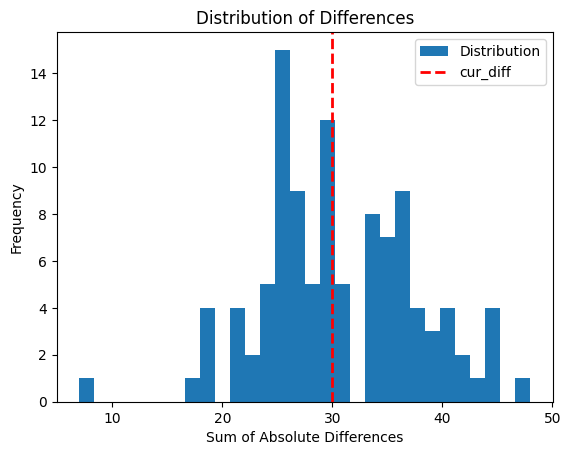

In [ ]:
# prompt: get the distributino of [sum(abs(X_test[0] - X_train[i])) for i in range(len(X_train))],
# put the cur_diff in the distribution, but with a different color to highlight it

import matplotlib.pyplot as plt

# Calculate the distribution
distribution = [sum(abs(X_test[test_case_index] - X_train[i])) for i in range(len(X_train))]

# Plot the distribution
plt.hist(distribution, bins=30, label='Distribution')

# Highlight cur_diff
plt.axvline(cur_diff, color='red', linestyle='dashed', linewidth=2, label='cur_diff')

plt.xlabel('Sum of Absolute Differences')
plt.ylabel('Frequency')
plt.title('Distribution of Differences')
plt.legend()
plt.show()


### 6.5 Show the two cases side by side, highlighting top and least important features

In [ ]:
def side_by_side_feature_comparison(f1, f2, five_features):
  for i in range(num_features_to_show):
      print(f"Feature {five_features[i]}: {f1[five_features[i]]} vs {f2[five_features[i]]}")
      print("\t"+columns[five_features[i]])

In [ ]:
#side by side comparison of their labels
print(y_test[test_case_index], " vs ", y_train[top_case_indices[test_case_index][0]])

tensor(1)  vs  tensor(1)


In [ ]:
side_by_side_feature_comparison(X_test[test_case_index], X_train[top_case_indices[test_case_index][0]], top_5_features)
#left is new client (query)
#right is the retrieved case

Feature 6: 1.0 vs 1.0
	7. My hobbies are still important to me
Feature 60: 1.0 vs 0.0
	61. Sometimes I forget what I wanted to say because I have several thoughts at the same time
Feature 73: 1.0 vs 1.0
	74. People have problems because of themselves
Feature 59: 1.0 vs 1.0
	60. In new situations I feel calm and encouraged
Feature 63: 1.0 vs 1.0
	64. I can put down my cell phone and dedicate myself to reading without distractions
Feature 95: 0.0 vs 0.0
	96. Littering on public roads is wrong
Feature 74: 0.0 vs 0.0
	75. No me parece importante lo que los otros piensen sobre mí
Feature 96: 0.0 vs 0.0
	97. People who commit crimes have their reasons for doing it
Feature 49: 1.0 vs 0.0
	50. I imagine that at any moment a disaster of the
nature may occur
Feature 52: 1.0 vs 1.0
	53. I'm bothered by people walking slowly in front of me 


In [ ]:
side_by_side_feature_comparison(X_test[test_case_index], X_train[top_case_indices[test_case_index][0]], least_5_features)

Feature 55: 1.0 vs 1.0
	56. I manage my schedule as I always have
Feature 68: 1.0 vs 0.0
	69. It is not important for me to meet set dates
Feature 101: 1.0 vs 1.0
	102. I have a hard time taking  "no" for an answer
Feature 34: 1.0 vs 0.0
	35. I constantly imagine that something will go wrong at my work or at school
Feature 91: 0.0 vs 0.0
	92. It does not seem serious to me to have some debts
Feature 4: 0.0 vs 1.0
	5. People around me often ask me how I feel
Feature 72: 1.0 vs 0.0
	73. I have difficulty making elaborate plans
Feature 36: 0.0 vs 0.0
	37. I'm not too worried about what might happen in a few weeks
Feature 94: 1.0 vs 1.0
	95. Neighbors must put up with each other's noises without complaining
Feature 100: 1.0 vs 0.0
	101. I consider it important that all people have the same rights


###Try the same thing on knn

In [ ]:
knn.predict(X_test)

array([1, 1, 1, 2, 1, 0, 2, 2, 1, 1, 0])

In [ ]:
y_test

tensor([0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1])

In [ ]:
indices = knn.kneighbors(X_test)[1][0]

In [ ]:
y_train[indices]

tensor([2, 1, 1, 2, 1])

In [ ]:
X_train[indices[0]]

tensor([1., 1., 1., 0., 0., 0., 1., 0., 1., 1., 0., 0., 1., 1., 1., 1., 1., 1.,
        1., 1., 1., 1., 1., 0., 1., 1., 1., 0., 1., 1., 0., 1., 1., 0., 1., 1.,
        0., 1., 0., 1., 1., 1., 1., 1., 1., 0., 1., 1., 1., 1., 0., 1., 1., 1.,
        1., 0., 0., 0., 0., 1., 1., 1., 0., 1., 1., 1., 1., 0., 1., 1., 1., 1.,
        1., 1., 0., 1., 1., 1., 1., 0., 0., 1., 1., 1., 1., 1., 0., 1., 0., 0.,
        1., 0., 1., 0., 1., 1., 0., 1., 0., 1., 1., 1.])

In [ ]:
print(X_train[indices[0]].tolist())

[1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 1.0, 1.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 0.0, 1.0, 0.0, 1.0, 1.0, 1.0]


In [ ]:
y_train[indices[0]]

tensor(2)

In [ ]:
sum(abs(X_test[0] - X_train[indices[0]]))

tensor(28.)

In [ ]:
#side by side comparison of labels
print(y_test[0], " vs ", y_train[indices[0]])

tensor(0)  vs  tensor(2)


In [ ]:
side_by_side_feature_comparison(X_test[0], X_train[indices[0]], top_5_features)

Feature 94: 1.0 vs 1.0
	95. Neighbors must put up with each other's noises without complaining
Feature 79: 1.0 vs 0.0
	80. It is important to help people when they need it
Feature 99: 1.0 vs 1.0
	100. I could pretend to be someone else to achieve what I want
Feature 88: 1.0 vs 0.0
	89. It makes me laugh when my superiors at school or at work demand something
Feature 46: 0.0 vs 1.0
	47. I can clearly express to others how I feel
Feature 12: 1.0 vs 1.0
	13. I felt more encouraged to do my daily activities before
Feature 80: 0.0 vs 0.0
	81. I have punched someone or thought of doing it
Feature 8: 1.0 vs 1.0
	9. If I had the chance, I would spend all day in my bed
Feature 22: 0.0 vs 1.0
	23. I have thought more than before about what my death would be like
Feature 42: 0.0 vs 1.0
	43. Sometimes i feel trapped


In [ ]:
side_by_side_feature_comparison(X_test[0], X_train[indices[0]], least_5_features)

Feature 50: 0.0 vs 0.0
	51. Sometimes I feel like I get tired easily
Feature 28: 1.0 vs 1.0
	29. I am able to carry out my activities as I have always been
Feature 55: 1.0 vs 0.0
	56. I manage my schedule as I always have
Feature 35: 0.0 vs 1.0
	36. I am afraid of being worng when doing my homework
Feature 84: 1.0 vs 1.0
	85. I have a hard time controlling myself when I get angry
Feature 72: 1.0 vs 1.0
	73. I have difficulty making elaborate plans
Feature 44: 1.0 vs 1.0
	45. I have difficulties to do one task at a time
Feature 6: 1.0 vs 1.0
	7. My hobbies are still important to me
Feature 58: 0.0 vs 0.0
	59. I consider that I am good at controlling my emotions
Feature 20: 1.0 vs 1.0
	21. I'm capable of achieving what I propose to myself


# Sanity Check


## Classification Neural Network

In [ ]:
# Hyperparameters
input_size = X_train.shape[1]
hidden_size = 1024
num_classes = torch.unique(ys).shape[0]
learning_rate = 1e-5
batch_size = 16
epochs = 2000

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

# Define the neural network architecture for classification
class NeuralNet(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        super(NeuralNet, self).__init__()
        self.nn = nn.Sequential(
            nn.Linear(input_size, hidden_size ),
            nn.LeakyReLU(),
            nn.Linear(hidden_size , hidden_size // 2),
            # nn.Dropout(0.5),
            nn.LeakyReLU(),
            nn.Linear(hidden_size // 2, hidden_size // 4),
            # nn.Dropout(0.5),
            nn.LeakyReLU(),
            nn.Linear(hidden_size // 4, num_classes)
            )
        self.init_weights()

    def init_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Linear):
                torch.nn.init.xavier_uniform_(m.weight)
                if m.bias is not None:
                    m.bias.data.fill_(0)

    def forward(self, x):
        return self.nn(x)


In [ ]:
best_accuracies = []
for train_index, test_index in k_fold.split(Xs):
  train_loader = torch.utils.data.DataLoader(torch.utils.data.TensorDataset(X_train, y_train), batch_size=batch_size, shuffle=True)
  patience_counter = 0
  best_model = None
  best_accuracy = None
  # Initialize the model, loss function, and optimizer
  model = NeuralNet(input_size, hidden_size, num_classes)
  criterion = nn.CrossEntropyLoss()
  optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

  # Training loop
  for epoch in range(epochs):
    epoch_msg = True
    training_total_acc = 0.0
    training_total_loss = 0.0
    num_of_batches = len(train_loader)
    for X_train_batch, y_train_batch in train_loader:
      model.train()
      # Forward pass
      outputs = model(X_train_batch)
      loss = criterion(outputs, y_train_batch)

      # Backward and optimize
      _, predicted = torch.max(outputs, 1)
      training_total_acc += torch.sum(predicted == y_train_batch).item()

      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

      training_total_loss += loss.item()
      # if (i + 1) % 5 == 0
    if epoch == 0 or (epoch + 1) % 100 == 0:
      print(f"Epoch: {epoch + 1}, Training Loss: {training_total_loss/num_of_batches:.2f} Acc: {training_total_acc/num_of_batches:.2f}")
    # Testing the model
    model.eval()
    with torch.no_grad():
      outputs = model(X_test)
      loss = criterion(outputs, y_test)
      _, predicted = torch.max(outputs, 1)
      accuracy = torch.sum(predicted == y_test).item() / len(y_test)
      print(f'Accuracy on the test set: {accuracy * 100:.2f}%')
      if best_accuracy is None or accuracy > best_accuracy:
        best_accuracy = accuracy
        best_model = model
        patience_counter = 0
      else:
        patience_counter += 1
      if epoch_msg and (epoch + 1) % 100 == 0:
        epoch_msg = False
        print(f'Epoch [{epoch + 1}/{epoch}], Test Loss: {loss.item()}')
    if patience_counter >= cfg.patience:
      print("Best acc achieved: ", best_accuracy)
      break
  best_accuracies.append(best_accuracy)
  # break
print("NN Average accuracy:", np.mean(best_accuracies))

Epoch: 1, Training Loss: 1.11 Acc: 4.71
Accuracy on the test set: 36.36%
Accuracy on the test set: 27.27%
Accuracy on the test set: 27.27%
Accuracy on the test set: 18.18%
Accuracy on the test set: 18.18%
Accuracy on the test set: 18.18%
Accuracy on the test set: 18.18%
Accuracy on the test set: 18.18%
Accuracy on the test set: 27.27%
Accuracy on the test set: 18.18%
Accuracy on the test set: 18.18%
Accuracy on the test set: 18.18%
Accuracy on the test set: 18.18%
Accuracy on the test set: 27.27%
Accuracy on the test set: 27.27%
Accuracy on the test set: 27.27%
Accuracy on the test set: 27.27%
Accuracy on the test set: 27.27%
Accuracy on the test set: 18.18%
Accuracy on the test set: 18.18%
Accuracy on the test set: 18.18%
Accuracy on the test set: 18.18%
Accuracy on the test set: 18.18%
Accuracy on the test set: 18.18%
Accuracy on the test set: 27.27%
Accuracy on the test set: 27.27%
Accuracy on the test set: 27.27%
Accuracy on the test set: 27.27%
Accuracy on the test set: 27.27%
Acc

KeyboardInterrupt: 

## Regression Neural Network

In [ ]:
# Hyperparameters
input_size = X_train.shape[1]
hidden_size = 100
# num_classes = torch.unique(ys).shape[0]
learning_rate = 1e-5
batch_size = 16
epochs = 2000

In [ ]:
# prompt: a standard neural network with 3 fully connected layers for regression

import torch
import torch.nn as nn
import torch.nn.functional as F

class RegressionNet(nn.Module):
    def __init__(self, input_size):
        super(RegressionNet, self).__init__()
        self.nn = nn.Sequential(
            nn.Linear(input_size, hidden_size ),
            nn.LeakyReLU(),
            nn.Linear(hidden_size , hidden_size // 2),
            # nn.Dropout(0.5),
            nn.LeakyReLU(),
            nn.Linear(hidden_size // 2, hidden_size // 4),
            # nn.Dropout(0.5),
            nn.LeakyReLU(),
            nn.Linear(hidden_size // 4, 1)
            )
        self.init_weights()

    def init_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Linear):
                torch.nn.init.xavier_uniform_(m.weight)
                if m.bias is not None:
                    m.bias.data.fill_(0)

    def forward(self, x):
        return self.nn(x).squeeze()

In [ ]:
best_accuracies = []
for train_index, test_index in k_fold.split(Xs):
  # Get training and testing data
  X_train, X_test = Xs[train_index], Xs[test_index]
  y_train, y_test = ys[train_index], ys[test_index]
  train_loader = torch.utils.data.DataLoader(torch.utils.data.TensorDataset(X_train, y_train), batch_size=batch_size, shuffle=True)
  patience_counter = 0
  best_model = None
  best_accuracy = None
  model = RegressionNet(Xs.shape[1])
  optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
  for epoch in range(epochs):
    epoch_msg = True
    training_total_loss = 0.0
    num_of_batches = len(train_loader)
    for X_train_batch, y_train_batch in train_loader:
      model.train()
      # Forward pass
      outputs = model(X_train_batch)
      loss = criterion(outputs, y_train_batch)
      training_total_loss += loss.item()
      # Backward and optimize
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

    if epoch == 0 or (epoch + 1) % 3 == 0:
      print(f'Epoch: {epoch + 1}, Training Loss: {training_total_loss/num_of_batches:.2f}')

    # Testing the model
    model.eval()
    with torch.no_grad():
      outputs = model(X_test)
      loss = criterion(outputs, y_test)
      if best_accuracy is None or loss.item() < best_accuracy:
        best_accuracy = loss.item()
        best_model = model
        patience_counter = 0
      else:
        patience_counter += 1
      if epoch_msg and (epoch + 1) % 100 == 0:
        epoch_msg = False
        print(f'Epoch [{epoch + 1}/{epochs}], Test Loss: {loss.item()}')
        # print(f'Loss on the test set: {loss.item()}')
    if patience_counter >= cfg.patience:
      print("Best loss achieved: ", best_accuracy)
      break
  best_accuracies.append(best_accuracy)
print("NN Average accuracy:", np.mean(best_accuracies))


Epoch: 1, Training Loss: 1.15
Epoch: 3, Training Loss: 1.11
Epoch: 6, Training Loss: 1.06
Epoch: 9, Training Loss: 1.01
Epoch: 12, Training Loss: 0.97
Epoch: 15, Training Loss: 0.92
Epoch: 18, Training Loss: 0.89
Epoch: 21, Training Loss: 0.86
Epoch: 24, Training Loss: 0.82
Epoch: 27, Training Loss: 0.79
Epoch: 30, Training Loss: 0.76
Epoch: 33, Training Loss: 0.74
Epoch: 36, Training Loss: 0.71
Epoch: 39, Training Loss: 0.69
Epoch: 42, Training Loss: 0.66
Epoch: 45, Training Loss: 0.63
Epoch: 48, Training Loss: 0.61
Epoch: 51, Training Loss: 0.60
Epoch: 54, Training Loss: 0.58
Epoch: 57, Training Loss: 0.56
Epoch: 60, Training Loss: 0.54
Epoch: 63, Training Loss: 0.52
Epoch: 66, Training Loss: 0.51
Epoch: 69, Training Loss: 0.50
Epoch: 72, Training Loss: 0.48
Epoch: 75, Training Loss: 0.47
Epoch: 78, Training Loss: 0.45
Epoch: 81, Training Loss: 0.44
Epoch: 84, Training Loss: 0.43
Epoch: 87, Training Loss: 0.42
Epoch: 90, Training Loss: 0.40
Epoch: 93, Training Loss: 0.40
Epoch: 96, T

## SHAP Explanation

In [ ]:
!pip install shap


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 540.1/540.1 kB 11.9 MB/s eta 0:00:00


In [ ]:
import shap

# Wrap the model's prediction function for SHAP
def cla_model_predict(x):
    model.eval()
    with torch.no_grad():
        x = torch.from_numpy(x).float()
        output = model(x)
        probabilities = nn.functional.softmax(output, dim=1).numpy()
    return probabilities


In [ ]:
# Wrap the model's prediction function for SHAP
def reg_model_predict(x):
    model.eval()
    with torch.no_grad():
        x = torch.from_numpy(x).float()
        output = model(x).numpy()
    return output

In [ ]:
# Use SHAP to explain the model's predictions
explainer = shap.DeepExplainer(model, X_train)
shap_values = explainer.shap_values(X_test)

shap_values.shape: (11, 102, 3)
SHAP values for class 0:


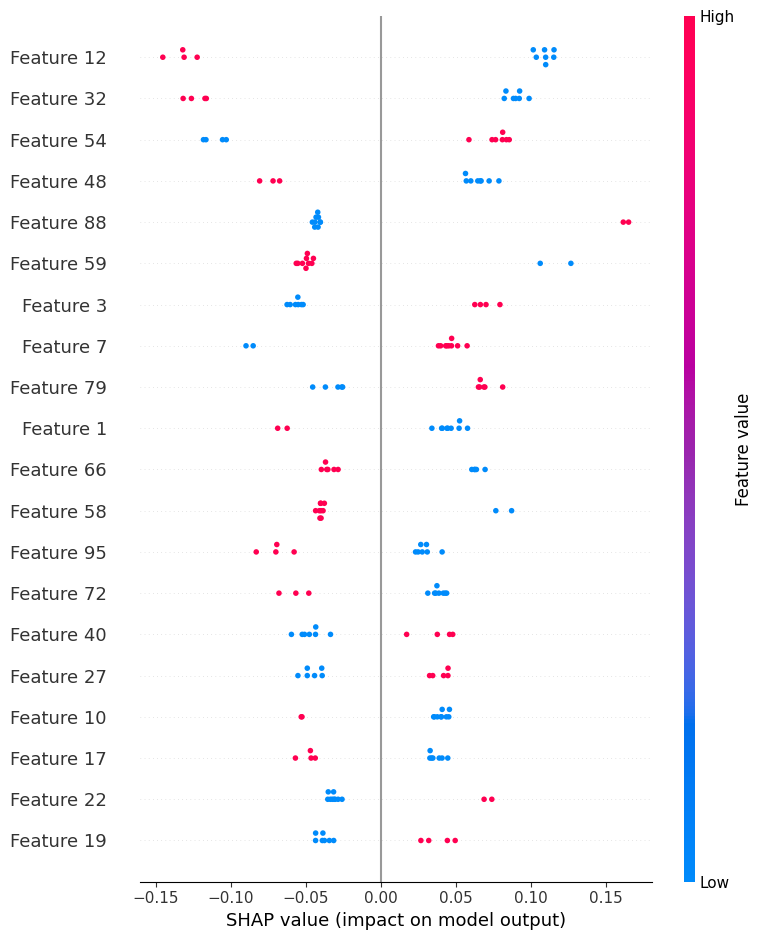

SHAP values for class 1:


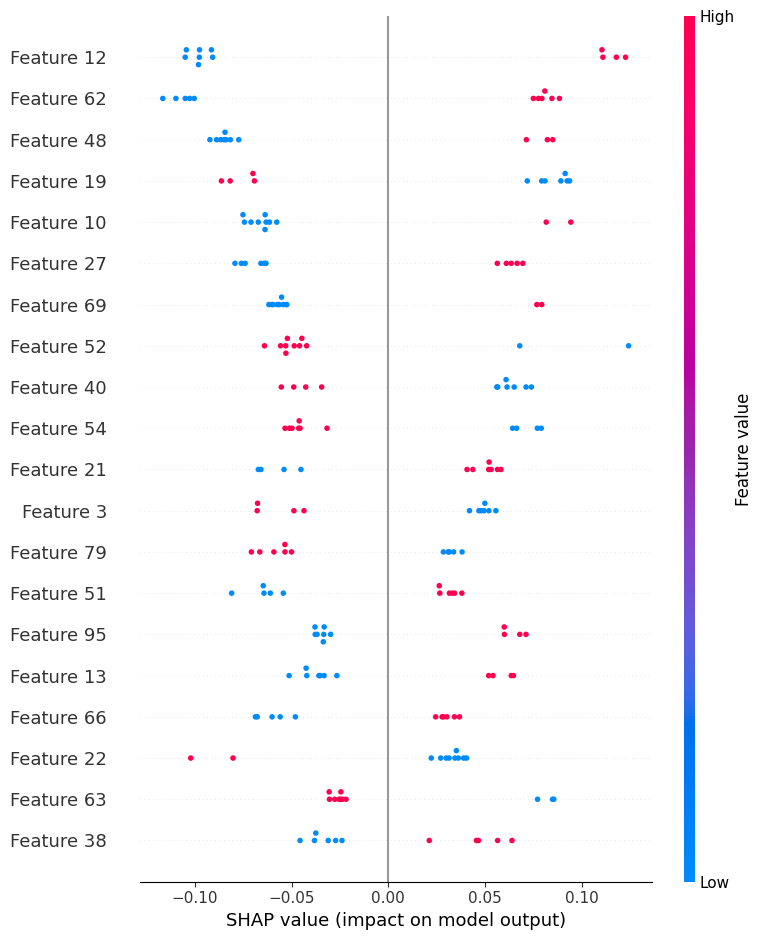

SHAP values for class 2:


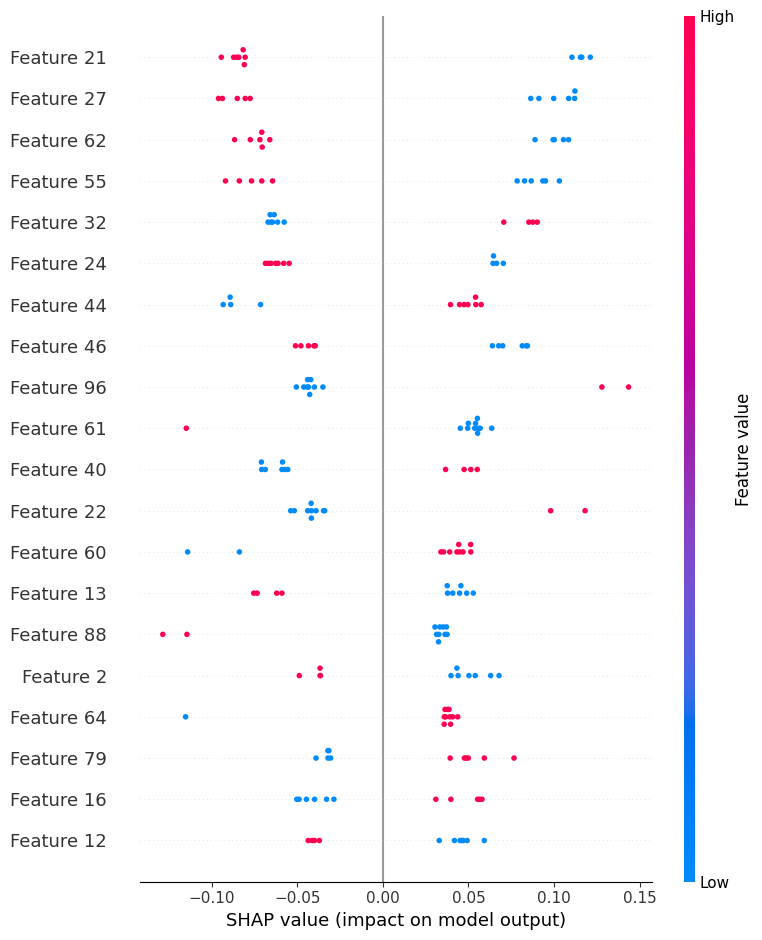

In [ ]:
# Check the shape of shap_values
print(f"shap_values.shape: {np.array(shap_values).shape}")

# Assuming shap_values has the shape (num_samples, num_features, num_classes)
num_classes = shap_values.shape[2]

# Iterate over each class and plot the SHAP values
for class_index in range(num_classes):
    print(f"SHAP values for class {class_index}:")
    shap_values_class = shap_values[:, :, class_index]
    shap.summary_plot(shap_values_class, X_test, feature_names=[f'Feature {i}' for i in range(input_size)])